In [1]:
import sys
import warnings
import time
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
class WhileLoopError(Exception):
    pass

In [4]:
class Environment:
    def __init__(self):
        self.states_ = None
        self.rewards_ = {}
        self.gamma_ = 0
        self.starting_grid_ = None
        self.goal_grid_ = None
        self.death_grid_ = None
        self.soft_wind_cols_ = []
        self.hard_wind_cols_ = []
        self.dim1_ = None
        self.dim2_ = None
    

    def set_states(self, dim1, dim2):
        if not isinstance(dim1, int) or not isinstance(dim2, int):
            raise Exception("Dimensions of the Grid must be interger!")
        elif dim1 < 0 or dim2 < 0:
            raise Exception("Dimensions must be positive")
        else:
            self.states_ = [(a,b) for a in range(dim1) for b in range(dim2)]
            self.dim1_ = dim1
            self.dim2_ = dim2
    
    def set_rewards(self, val):
        if type(val) is not tuple and len(val) != 4:
            raise Exception("Rewards must be a tuple of dimension 3")
        for v in val:
            if type(v) is not int and type(v) is not float:
                raise Exception("Rewards value must be interger or float")
        self.rewards_['move'] = val[0]
        self.rewards_['death'] = val[1]
        self.rewards_['terminal'] = val[2]

    def set_discount(self, val):
        if type(val) is not int and type(val) is not float:
            raise Exception("Discount ratio must be interger or float")
        elif val < 0 or val > 1:
            raise Exception("Discount ratio must be in range (0,1)")
        else:
            self.gamma_ = val

    def set_starting_grid(self, state):
        if type(state) is not tuple and len(state) != 2:
            raise Exception("Starting state must be a tuple in 2 dimension")
        elif state[0] >= self.get_dim()[0] or state[1] >= self.get_dim()[1]:
            raise Exception("Starting state must be within the gridworld")
        elif state == self.get_terminal_grid():
            raise Exception("Starting state cannot be the same as goal state")
        else:
            self.starting_grid_ = state
    
    def set_terminal_grid(self, state):

        if type(state) is not tuple and len(state) != 2:
            raise Exception("Goal state must be a tuple in 2 dimension")
        elif state[0] >= self.get_dim()[0] or state[1] >= self.get_dim()[1]:
            raise Exception("Goal state must be within the gridworld")
        elif state == self.get_death_grid():
            raise Exception("Goal state cannot be within death grid")
        elif state == self.get_starting_grid():
            raise Exception("Goal state cannot be the same as starting gird")
        else:
            self.goal_grid_ = state
    
    def set_death_grid(self,state):
        if type(state) is not tuple and len(state) != 2:
            raise Exception("Death state must be a tuple in 2 dimension")
        elif state[0] >= self.get_dim()[0] or state[1] >= self.get_dim()[1]:
            raise Exception("Death state must be within the gridworld")
        elif state == self.get_death_grid():
            raise Exception("This state already set to death state")
        elif state == self.get_starting_grid() or state == self.get_terminal_grid():
            raise Exception("Death state cannot be the same as starting gird or goal state")
        else:
            self.death_grid_ = state
    
    def set_soft_windy_columns(self, val:int):
        self.soft_wind_cols_.append(val)
    
    def set_hard_wind_columns(self, val:int):
        self.hard_wind_cols_.append(val)

    def get_rewards(self):
        return self.rewards_
    
    def get_states(self):
        return self.states_
    
    def get_discount(self):
        return self.gamma_
    
    def get_starting_grid(self):
        return self.starting_grid_
    
    def get_terminal_grid(self):
        return self.goal_grid_
    
    def get_death_grid(self):
        return self.death_grid_

    def get_dim(self):
        return (self.dim1_, self.dim2_)

    def get_soft_windy_cols(self):
        return self.soft_wind_cols_

    def get_hard_windy_cols(self):
        return self.hard_wind_cols_
            


In [5]:
class Agent(Environment):
    def __init__(self):
        super().__init__()
        self.actions_ = None
        self.v_ = None
        self.policy_ = None
        self.q_values = None
        self.q_optimized = None

    def set_full_actions(self):
        self.actions_ = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']    #king's move

    def set_restricted_actions(self):
        self.actions_ = ['N', 'W', 'S', 'E']                           # simple situation

    def init_v_and_policy(self):
        self.set_v(np.zeros(int(self.get_dim()[0] * self.get_dim()[1])))
        self.set_policy(np.array(['X' for _ in range(int(self.get_dim()[0] * self.get_dim()[1]))]))

    def init_q_values(self):
        # for s in self.get_states():
        #     print(s)
        # for a in self.get_actions():
        #     print(a)
        self.q_values = {(s,a):0 for s in self.get_states() for a in self.get_actions()}

    def set_v(self, vector):
        self.v_ = vector
    
    def set_policy(self, vector):
        self.policy_ = vector

    def get_q_values(self):
        return self.q_values
    
    def get_actions(self):
        return self.actions_
    
    def get_v(self):
        return self.v_
    
    def get_policy(self):
        return self.policy_
    
    def wind_move(self, state):
        temp_s = state

        if temp_s[1] in self.get_soft_windy_cols():
            temp_s = (temp_s[0] - 1, temp_s[1])
        elif temp_s[1] in self.get_hard_windy_cols():
            temp_s = (temp_s[0] - 2, temp_s[1])
        
        return temp_s
    
    def wall_move(self, state):
        temp_s = state
        
        if temp_s[0] >= self.get_dim()[0]:
            temp_s = (self.get_dim()[0] - 1, temp_s[1])
        elif temp_s[0] < 0:
            temp_s = (0 , temp_s[1])
        elif temp_s[1] >= self.get_dim()[1]:
            temp_s = (temp_s[0], self.get_dim()[1] - 1)
        elif temp_s[1] < 0:
            temp_s = (temp_s[0], 0)

        return temp_s

    def move_conditions(self, state, action):

        if action == 'N':
            temp_s = (state[0] - 1, state[1])
        elif action == 'S':
            temp_s = (state[0] + 1, state[1])
        elif action == 'W':
            temp_s = (state[0], state[1] - 1)
        elif action == 'E':
            temp_s = (state[0], state[1] + 1)
        elif action == 'NE':
            temp_s = (state[0] - 1, state[1] + 1)
        elif action == 'NW':
            temp_s = (state[0] - 1, state[1] - 1)
        elif action == 'SE':
            temp_s = (state[0] + 1, state[1] + 1)
        elif action == 'SW':
            temp_s = (state[0] + 1, state[1] - 1)
        else:
            raise Exception("Invalid action")
        
        # testify whether hit the border
        temp_s = self.wall_move(temp_s)
        # move according to wind strength
        temp_s = self.wind_move(temp_s)
        # testify whether hit the border
        temp_s = self.wall_move(temp_s)

        return temp_s
    
    def reward_policy(self, state):

        if state == self.get_terminal_grid():
            return self.get_rewards()['terminal']
        elif state == self.get_death_grid():
            return self.get_rewards()['death']
        elif state == None:
            return 0
        else:
            return self.get_rewards()['move']
    
    


        

In [6]:
class TD:
    # def __init__(self):
    #     super().__init__()
    
    def policy(self, state ,action):
        if state == agent.get_terminal_grid() and state == agent.get_death_grid():
            return None
        else:
            state_prime = agent.move_conditions(state, action)
            reward = agent.reward_policy(state_prime)
            action_prime = np.random.choice(agent.get_actions())
            return (state, action, reward, state_prime, action_prime)
        
    def random_state(self):
        """
        define the start state
        """
        length = len(agent.get_states())
        random_index = np.random.randint(length)
        start_state = agent.get_states()[random_index]
        while start_state == agent.get_death_grid() or start_state == agent.get_terminal_grid():
            random_index = np.random.randint(length)
            start_state = agent.get_states()[random_index]
        return start_state
    
    def Sarsa(self, step_size = 0.01, iteration = 50000):
        start_time = time.time()
        j = 1

        for i in range(iteration):
            # print('iteration', i)
            state = self.random_state()
            action = np.random.choice(agent.get_actions())
            if (i % int(iteration/5) == 0 and i > 1) or (i == iteration - 1):
                print('{}% SARSA DONE in {:.2f}s'.format(20*j, end_time - start_time))
                j += 1
            while state != agent.get_terminal_grid() and state != agent.get_death_grid():
                (state, action, reward, state_prime, action_prime) = self.policy(state, action)
                agent.get_q_values()[state, action] = agent.get_q_values()[state, action] + step_size * (reward + agent.gamma_ * agent.get_q_values()[state_prime, action_prime] - agent.get_q_values()[state, action])
                (state, action) = (state_prime, action_prime)

                if state == agent.get_terminal_grid() or state == agent.get_death_grid:
                    end_time = time.time()

    
    def Q_Learning(self, step_size = 0.01, iteration = 50000, epsilon = 0.99):
        start_time = time.time()
        j = 1
        greedy_count = 0
        exploration_count = 0

        for i in range(iteration):
            # print('iteration', i)
            state = self.random_state()
            action = np.random.choice(agent.get_actions())
            epsilon *= epsilon

            if (i % int(iteration/5) == 0 and i > 1) or (i == iteration - 1):
                print('{}% Q_LEARNING DONE in {:.2f}s'.format(20*j, end_time - start_time))
                j += 1
                print("Greedy:{:.2f}% and Random:{:.2f}%".format(100 * (greedy_count / (greedy_count + exploration_count)), 100 * (exploration_count / (greedy_count + exploration_count))))
            # while state != agent.get_terminal_grid() and state != agent.get_death_grid():
            while state != agent.get_terminal_grid():
                prob = np.random.random()
                
                if prob >= epsilon and i > int(0.05 * iteration):
                    # greedy search 
                    action = agent.get_actions()[np.argmax([agent.get_q_values()[state, action] for action in agent.get_actions()])]
                    greedy_count += 1
                else:
                    # within 5% of generation, explore more
                    action = np.random.choice(agent.get_actions())
                    exploration_count +=1

                state_prime = agent.move_conditions(state, action)
                reward = agent.reward_policy(state_prime)
                agent.get_q_values()[state, action] = agent.get_q_values()[state, action] + step_size * (reward + agent.gamma_ * np.max([agent.get_q_values()[state_prime, a] for a in agent.get_actions()]) - agent.get_q_values()[state, action])
                # agent.get_q_values()[state, action] = agent.get_q_values()[state, action] + step_size * (reward + agent.gamma_ * np.max([agent.get_q_values()[s_prime,a] for a in self.get_actions()]) - self.get_q_values()[s,a])
                state = state_prime
                
                if state == agent.get_terminal_grid() or state == agent.get_death_grid():
                    end_time = time.time()

    def compute_optimal_actions(self):
        agent.q_optimized = [(state, agent.get_actions()[np.argmax([agent.get_q_values()[state, action] for action in agent.get_actions()])]) for state in agent.get_states()]
        # agent.q_optimized = [(state, agent.get_actions()[np.argmax([agent.get_q_values()[state, action] for action in agent.get_actions()])]) for state in agent.get_states()]
    
    def find_optimal_action(self, state):
        for s, a in agent.q_optimized:
            if s == state:
                return a 
    





In [7]:
def plot_optimal_grid(agent):
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111)
    data = np.empty ((agent.get_dim()[0] + 2, agent.get_dim()[1])) * np.nan
    cax = ax.matshow(data, cmap = 'binary')
    
    for state, action in agent.q_optimized:
        if state == agent.get_terminal_grid() or state == agent.get_death_grid():
            ax.text(state[1]+0.5, state[0]+0.5, action, color='blue', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='blue'))
        elif state == agent.get_starting_grid():
            ax.text(agent.get_starting_grid()[1]+0.5, agent.get_starting_grid()[0]+0.75, action, color='green', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='green'))
            
    ax.text(agent.get_starting_grid()[1]+0.5, agent.get_starting_grid()[0]+0.25, 'Start', color='green', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='green'))

    # ax.text(agent.get_death_grid()[1]+0.5, agent.get_death_grid()[0]+0.5, 'X', color='red', ha='center', va='center', fontsize = 40)

    ax.text(agent.get_terminal_grid()[1]+0.5, agent.get_terminal_grid()[0]+0.5, 'G', color = 'red', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))
    
    for soft_wind in agent.get_soft_windy_cols():
        ax.text(soft_wind+0.5, agent.get_dim()[0]+0.5, u'\u2191', color='gray', ha='center', va='center', fontsize = 40,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

    for hard_wind in agent.get_hard_windy_cols():
        ax.text(hard_wind+0.5, agent.get_dim()[0]+0.5, u'\u2191', color='gray', ha='center', va='center', fontsize = 40,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
        ax.text(hard_wind+0.5, agent.get_dim()[0]+1.5, u'\u2191', color='gray', ha='center', va='center', fontsize = 40,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
        
    extent = (0, data.shape[1], data.shape[0], 0)
    ax.set_xticks(np.arange(0,10,1))
    ax.grid(which = 'major', color='k',lw=2)
    # ax.fill_between([9,10], 4, 5, facecolor='black')
    # ax.fill_between([0,10], 7, 9, facecolor='black')
    ax.imshow(data, extent=extent)
    plt.savefig('optimal_grid.png')
    plt.show()
        
def plot_optimal(agent, td, algorithm_name):
    fig = plt.figure(figsize = (14,14))
    ax  = fig.add_subplot(111)
    # data = np.empty((agent.get_dim()[0]+2, agent.get_dim()[1])) * np.nan
    data = np.empty((agent.get_dim()[0], agent.get_dim()[1])) * np.nan
    cax = ax.matshow(data, cmap = 'binary')
    curr_state = agent.get_starting_grid()

    count = 0 
    # while curr_state != agent.get_terminal_grid() and curr_state != agent.get_death_grid():
    while curr_state != agent.get_terminal_grid():
        count += 1
        # print('count', count)
        action = td.find_optimal_action(curr_state)
        if curr_state == agent.get_starting_grid():
            ax.text(curr_state[1]+0.5, curr_state[0]+0.75, action, color='red', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))
            curr_state = agent.move_conditions(curr_state, action)
            # continue
        else:
            ax.text(curr_state[1]+0.5, curr_state[0]+0.5, action, color='red', ha='center', va='center', fontsize = 20,
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))
            curr_state = agent.move_conditions(curr_state, action)

        if count == 1e4:
            # plot_optimal_grid(agent)
            # return None
            break
        
    ax.text(agent.get_starting_grid()[1]+0.5, agent.get_starting_grid()[0]+0.25, 'Start', color='black', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

    # ax.text(agent.get_death_grid()[1]+0.5, agent.get_death_grid()[0]+0.5, 'X', color='red', ha='center', va='center', fontsize = 40)

    ax.text(agent.get_terminal_grid()[1]+0.5, agent.get_terminal_grid()[0]+0.5, 'Goal', color = 'red', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))
    
    for soft_wind in agent.get_soft_windy_cols():
        ax.text(soft_wind+0.5, agent.get_dim()[0], 1, color='gray', ha='center', va='center', fontsize = 20,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
        # ax.text(soft_wind+0.5, agent.get_dim()[0]+0.5, u'\u2191', color='gray', ha='center', va='center', fontsize = 40,
        #         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
        
    for hard_wind in agent.get_hard_windy_cols():
        ax.text(hard_wind + 0.5, agent.get_dim()[0], 2, color = 'gray', ha = 'center', va = 'center', fontsize = 20,
                bbox =dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))
        # ax.text(hard_wind + 0.5, agent.get_dim()[0] + 0.5, u'\u2191', color = 'gray', ha = 'center', va = 'center', fontsize = 40,
        #         bbox =dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))
    
    extent = (0, data.shape[1], data.shape[0], 0)
    ax.set_xticks(np.arange(0,10,1))
    # ax.set_yticks(np.arange(0,10,1))
    ax.grid(which = 'major', color='k',lw=2)
    # ax.fill_between([9,10], 4, 5, facecolor='black')
    ax.fill_between([0,10], 7, 9, facecolor='black')
    ax.imshow(data, extent=extent)
    plt.savefig(f'windy_gridworld_{algorithm_name}.png')
    plt.show()

In [8]:
env = Environment()
agent = Agent()
td = TD()

## easy case, action ('S', 'N', 'W', 'E')

In [9]:
agent.set_states(7,10)
agent.set_rewards((-1, -100, 0))
agent.get_rewards()
agent.set_discount(1)
# agent.set_full_actions()
agent.set_restricted_actions()
agent.init_q_values()

print("Agent Set of Actions:", agent.get_actions())

Agent Set of Actions: ['N', 'W', 'S', 'E']


In [10]:
agent.set_starting_grid((3, 0))
agent.set_terminal_grid((3, 7))
# agent.set_death_grid((4, 9))

In [11]:
for x in [3,4,5,8]:
    agent.set_soft_windy_columns(x)

for x in [6,7]:
    agent.set_hard_wind_columns(x)

print("WindyGridWorld Columns for the Soft Wind:", agent.get_soft_windy_cols())
print("WindyGridWorld Columns for the Hard Wind:", agent.get_hard_windy_cols())

WindyGridWorld Columns for the Soft Wind: [3, 4, 5, 8]
WindyGridWorld Columns for the Hard Wind: [6, 7]


In [12]:
# Sarsa
agent.init_q_values()
td.Sarsa(step_size=0.01, iteration=50000)
td.compute_optimal_actions()


20% SARSA DONE in 1815.38s
40% SARSA DONE in 3597.40s
60% SARSA DONE in 5342.76s
80% SARSA DONE in 7100.19s
100% SARSA DONE in 8893.94s


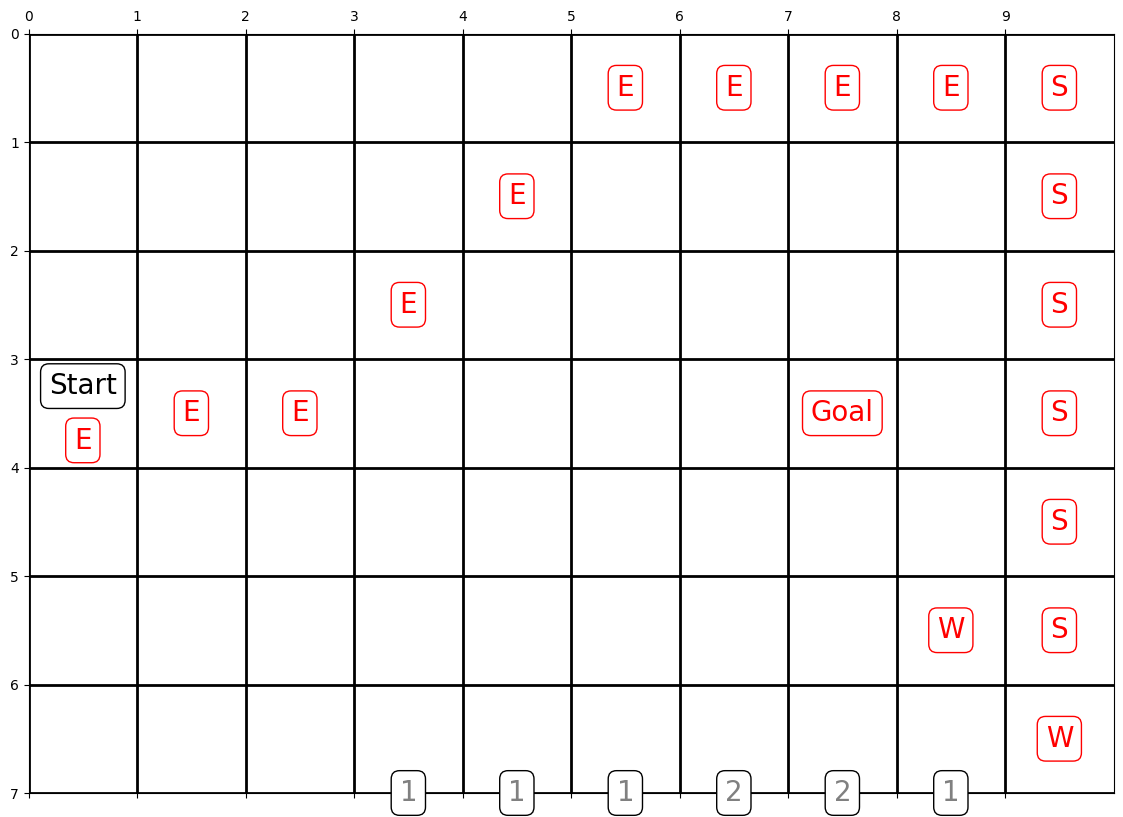

In [13]:
plot_optimal(agent, td, 'Sarsa')

In [14]:
# Q-learning
agent.init_q_values()
td.Q_Learning(step_size=0.01, iteration=50000, epsilon=0.6)
td.compute_optimal_actions()


20% Q_LEARNING DONE in 703.01s
Greedy:0.10% and Random:99.90%
40% Q_LEARNING DONE in 703.93s
Greedy:0.24% and Random:99.76%
60% Q_LEARNING DONE in 704.85s
Greedy:0.38% and Random:99.62%
80% Q_LEARNING DONE in 705.74s
Greedy:0.51% and Random:99.49%
100% Q_LEARNING DONE in 706.64s
Greedy:0.64% and Random:99.36%


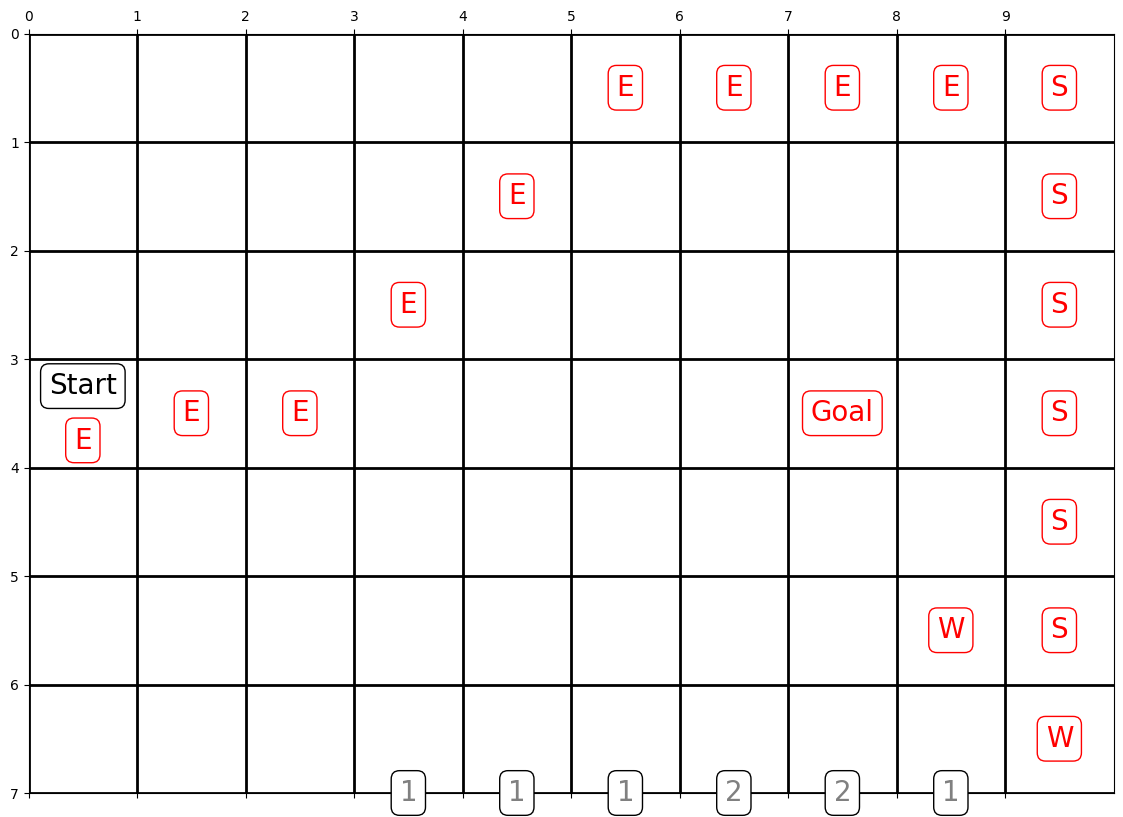

In [15]:
plot_optimal(agent, td, 'Q-learning')

## King's move, action ('S', 'N', 'E', 'W', 'SE', 'SW', 'NE', 'NW')

In [16]:
# king's move
agent.set_full_actions()
print(agent.get_actions())

['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']


In [17]:
# Sarsa with king's move
agent.init_q_values()
td.Sarsa(step_size=0.01, iteration=50000)
td.compute_optimal_actions()

20% SARSA DONE in 790.12s
40% SARSA DONE in 1577.35s
60% SARSA DONE in 2383.31s
80% SARSA DONE in 3210.54s
100% SARSA DONE in 4009.03s


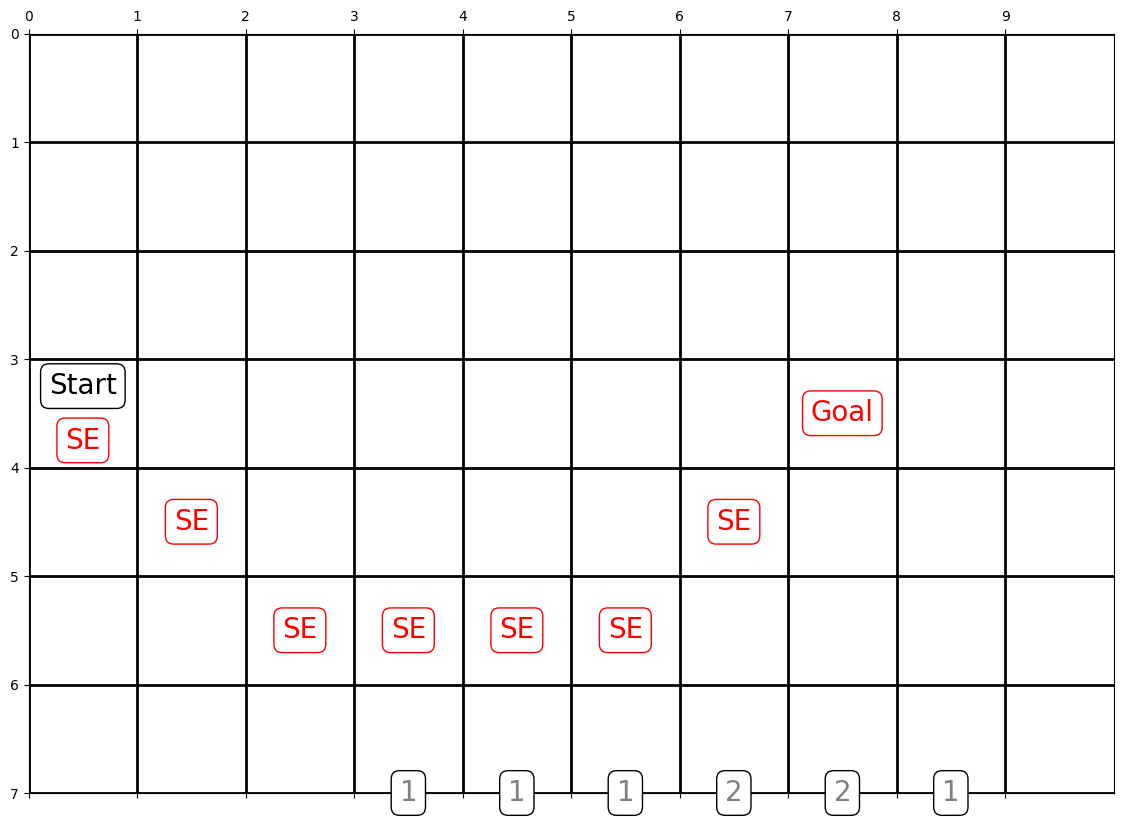

In [18]:
plot_optimal(agent, td, 'Sarsa_King')

In [19]:
# Q-learning with king's move
agent.init_q_values()
td.Q_Learning(step_size=0.01, iteration=50000, epsilon=0.99)
td.compute_optimal_actions()

20% Q_LEARNING DONE in 319.26s
Greedy:0.13% and Random:99.87%
40% Q_LEARNING DONE in 319.85s
Greedy:0.30% and Random:99.70%
60% Q_LEARNING DONE in 320.42s
Greedy:0.46% and Random:99.54%
80% Q_LEARNING DONE in 321.00s
Greedy:0.63% and Random:99.37%
100% Q_LEARNING DONE in 321.58s
Greedy:0.80% and Random:99.20%


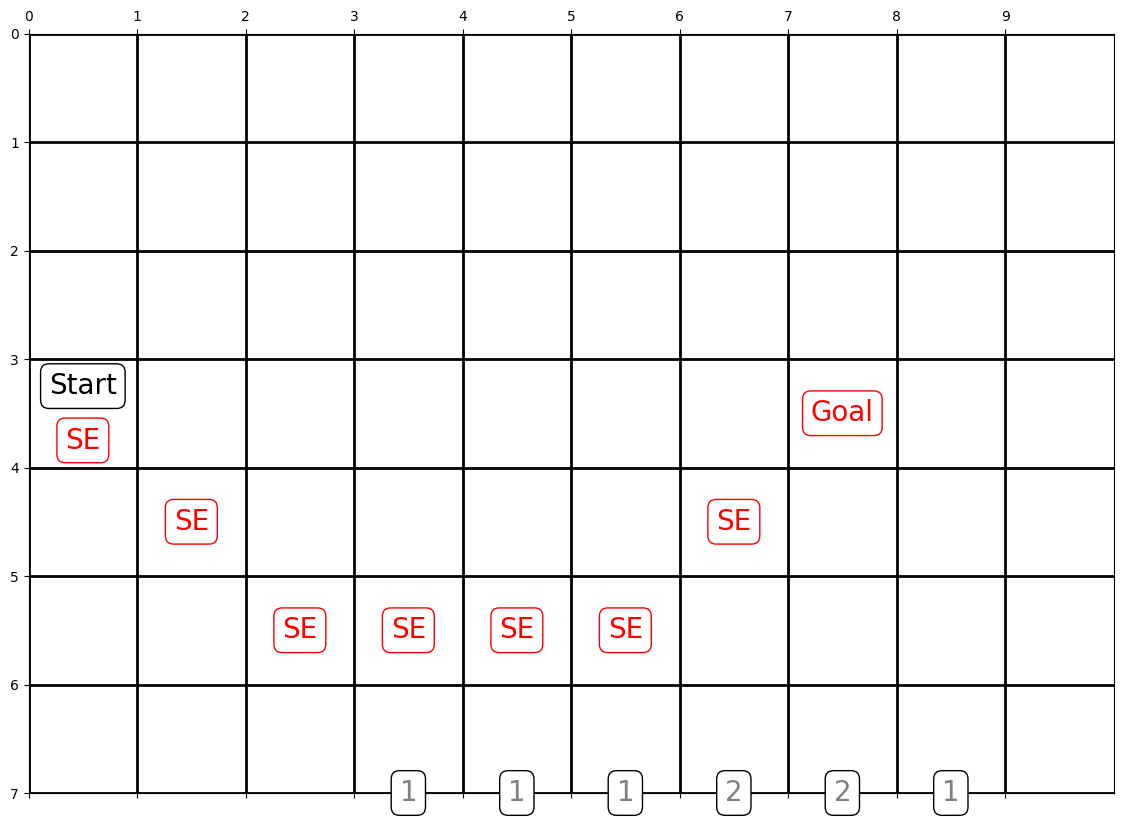

In [20]:
plot_optimal(agent, td, 'Q-learning_King')